# Kaggle Fruits 360 with CNN
let's work the same data with a <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>Convolutional Neural Network</a> (CNN).
You'll want to be comfortable with below theories:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from torchvision.datasets import ImageFolder

## Load the Fruits360 dataset
PyTorch load data using torchvision's ImageFolder 
Refer to: 
<a href='https://pytorch.org/docs/stable/data.html#torchvision.datasets.ImageFolder'><tt><strong>ImageFolder</strong></tt></a>.

Refer for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [25]:
transform = transforms.ToTensor()

train_data = ImageFolder(root='fruits-360/Training', transform=transform)
test_data = ImageFolder(root='fruits-360/Test', transform=transform)

In [26]:
train_data

Dataset ImageFolder
    Number of datapoints: 67692
    Root Location: fruits-360/Training
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [27]:
test_data

Dataset ImageFolder
    Number of datapoints: 22688
    Root Location: fruits-360/Test
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

### Create loaders
When working with images, we want relatively small batches; a batch size of 4 is not uncommon.

In [28]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Define a convolutional model
CNN with input layer of 10000 (our flattened 100x100 images), and an output size representing 131 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

In [29]:
# Define layers
# out_channels: filters, 
#nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1)
conv1 = nn.Conv2d(3, 8, 3, 1) # ----> 6 filters -----> pooling ----> conv2
# arbitrary value for filters
conv2 = nn.Conv2d(8, 16, 3, 1)

In [30]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [31]:
X_train.shape

torch.Size([3, 100, 100])

In [32]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)

x = X_train.view(1,3,100,100)
print(x.shape)

torch.Size([1, 3, 100, 100])


In [33]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape) # [1, 8, 98, 98] ----> 98 = 100 - 3(kernel) + 1(stride)

torch.Size([1, 8, 98, 98])


In [34]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 8, 49, 49])


In [35]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 47, 47])


In [36]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2) # [1, 16, 23, 23] ---> 47/2=23.5
#( (pixel - 2)/2<pooling> - 2<kernel loss> ) /2
# 100-2
print(x.shape)

torch.Size([1, 16, 23, 23])


In [37]:
((100-2)/2-2)/2

23.5

In [38]:
x.shape

torch.Size([1, 16, 23, 23])

In [39]:
# Flatten the data
# -1: keep the first dimension, batch size
x = x.view(-1, 16*23*23)
print(x.shape)

torch.Size([1, 8464])


<div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>

Now let's run the code.

In [59]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        # 120 is arbitrary choice of how many nutron we want
        self.fc1 = nn.Linear(16*23*23, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200,131)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*23*23)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [60]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8464, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=131, bias=True)
)

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}$<br>

In [61]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [62]:
count_parameters(model)

   216
     8
  1152
    16
2539200
   300
 60000
   200
 26200
   131
______
2627423


## Define loss function & optimizer

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [64]:
import time
start_time = time.time()

epochs = 1
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 2.33298063  accuracy:  20.150%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.41475028  accuracy:  40.800%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.21058294  accuracy:  53.761%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.51151675  accuracy:  62.237%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.36114097  accuracy:  68.057%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.15932700  accuracy:  72.300%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00729241  accuracy:  75.474%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00024594  accuracy:  77.956%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.03497309  accuracy:  79.969%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00926496  accuracy:  81.523%
epoch:  0  batch: 6600 [ 66000/60000]  loss: 0.00521486  accuracy:  82.914%

Duration: 537 seconds


## Plot the loss and accuracy comparisons

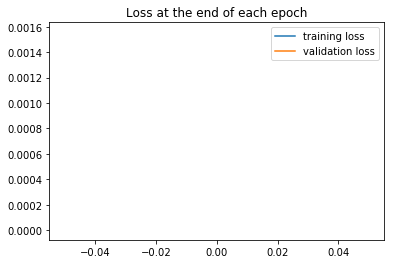

In [65]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [67]:
train_losses

[tensor(0.0016, grad_fn=<NllLossBackward>)]

In [66]:
test_losses

[tensor(2.2799e-06)]

While there may be some overfitting of the training data, there is far less than we saw with the ANN model.

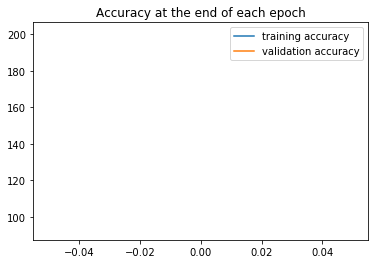

In [68]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [57]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Recall that our [784,120,84,10] ANN returned an accuracy of 97.25% after 10 epochs. And it used 105,214 parameters to our current 60,074.

## Display the confusion matrix

In [25]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 977    0    3    2    2    2    4    1   10    2]
 [   0 1132    5    1    1    0    3    7    1    2]
 [   0    0 1015    1    0    0    0    4    3    0]
 [   0    2    0 1001    0   11    0    1    3    4]
 [   0    0    1    0  966    0    1    0    2    2]
 [   0    0    0    1    0  863    2    0    0    2]
 [   1    0    0    0    3    4  948    0    0    0]
 [   1    0    5    0    0    1    0 1005    1    2]
 [   1    1    3    4    1    4    0    2  948    2]
 [   0    0    0    0    9    7    0    8    6  993]]


## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [26]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

152

In [27]:
# Display the first 10 index positions
misses[:10]

array([  18,  111,  175,  184,  247,  321,  340,  412,  445,  460],
      dtype=int64)

In [28]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

Index: [  18  111  175  184  247  321  340  412  445  460  495  582]
Label: [   3    7    7    8    4    2    5    5    6    5    8    8]
Guess: [   8    1    1    3    6    7    3    3    0    9    0    2]


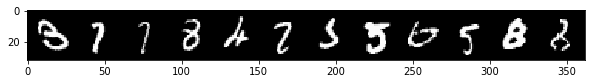

In [30]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

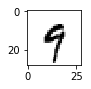

In [31]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [32]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9


## Great job!